### spatial selection use healpy

the notebook demonstrates how to select

- [polygon](#select-polygon)
- [disc](#select-disc)
- [ring](#select-ring)
- [Galactic avoidance region](#galactic-plane)
- [Ecliptic region](#ecliptic)

run [utils](#utils) cell first 

In [240]:
import numpy as np
import pandas as pd
import healpy as hp

import matplotlib.pyplot as plt
%matplotlib inline


#### prepare Fields.csv, 

skip to [load Fields.csv]( #read-Fields.csv) if already have the file

In [288]:
NSIDE = 16
NPIX = hp.nside2npix(NSIDE)

Fields = pd.DataFrame()
Fields['pixId'] = np.arange(NPIX)
Fields['fieldRa'], Fields['fieldDec'] = pix2radec(nside=NSIDE, ipix=Fields['pixId'].values )
Fields['fieldGl'], Fields['fieldGb'] = radec2gal(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)
Fields['fieldEl'], Fields['fieldEb'] = radec2ecliptic(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)


In [4]:
# load a builtin star map
# only have star density for LSST footprint
starmap = load_starmap(flt='r')

In [5]:
def get_dens(df): 
    dens = get_starDensity(ra=df['fieldRa'], dec=df['fieldDec'], starMap=starmap, mag=25)
    if df['pixId']%100 == 0:
        print(df['pixId'])
    return dens


In [ ]:
# %%time 
# Fields['starDensity_r25'] = Fields.apply(get_dens, axis=1)
# Fields.to_csv("Fields_nside16.csv", index=False)

#### read Fields.csv

In [311]:
Fields = pd.read_csv("Fields_nside16.csv")
NSIDE = hp.npix2nside(Fields.shape[0])

In [312]:
Fields.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0


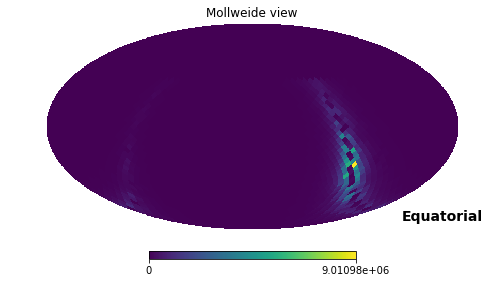

In [313]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['starDensity_r25'].values, fig=1, coord=['C'])

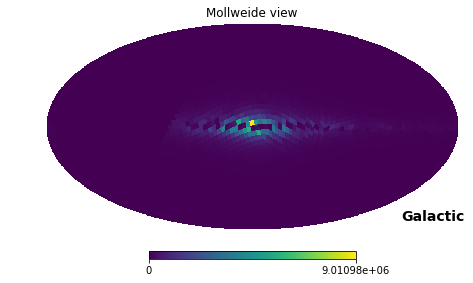

In [314]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['starDensity_r25'].values, fig=1, coord=['C', 'G'])
# hp.graticule() # add grid

#### select polygon

In [315]:
def radec2xyz(ra, dec):
    '''convert ra/dec to xyz'''
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    xyz = hp.ang2vec(theta, phi)
    
    return xyz

In [336]:
def get_masked_map(m, pixes, maskpix):
    '''create a masked map,'''
    mx = np.ma.masked_array(m, fill_value=hp.UNSEEN, dtype=np.double)
    #mask=[i in maskpix for i in pixes ]  
    mask = np.isin(pixes, maskpix)
    mx.mask = np.array(mask, dtype=np.bool)
    return mx


In [337]:
## polygon vertices defined by ra, dec in degree
## polygon vertices need to be in order
ra=[0, 60,  30, 330, 300] 
dec=[0, -15,  -45, -45, -15]

# convert to xyz coordinates
xyz = radec2xyz(ra, dec)  
# get masked pixes
ipix_poly = hp.query_polygon(NSIDE, xyz, inclusive=True)  


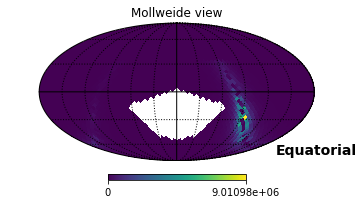

In [338]:
# create a masked map
m = get_masked_map(Fields['starDensity_r25'].values, Fields['pixId'].values, maskpix=ipix_poly) 

# visualize use healpy
fig = plt.figure(1, figsize=(4,4))

hp.mollview(m, fig=1, badcolor='white', coord=['C'], norm='linear')
hp.graticule()

In [339]:
# or add mask column to dataframe
# Fields['inpoly'] = [i in ipix_poly for i in Fields['pixId'].values]
Fields['inpoly'] = np.isin(Fields['pixId'].values, ipix_poly)

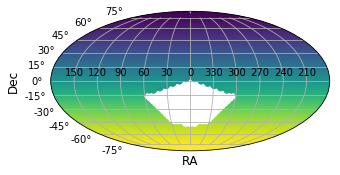

In [340]:
df = Fields
fig, ax = plt.subplots(1, 1, figsize=(5, 5),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['inpoly'] == False )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['pixId']
plot_mwd(ax, x, y, c, title='', colorbar=False) 

#### select disc

In [341]:
center = radec2xyz(ra=270, dec=0)
radius = np.deg2rad(15) 
ipix_disc = hp.query_disc(NSIDE, center, radius, inclusive=True)


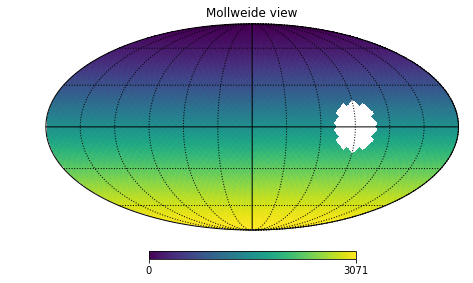

In [342]:
# create a masked map
m = get_masked_map(Fields['pixId'].values, Fields['pixId'].values, maskpix=ipix_disc) 

# visuzlize
fig = plt.figure(1, figsize=(6,6))
hp.mollview(m, fig=1, badcolor='white')
hp.graticule()

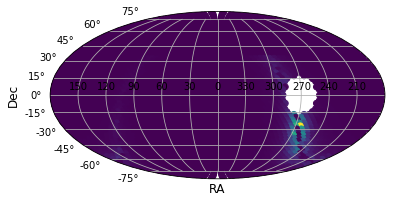

In [346]:

# create a mask column 
Fields['indisc'] = np.isin(Fields['pixId'].values, ipix_disc)
df = Fields
fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['indisc'] == False ) 
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 




#### select circle

In [348]:
center = radec2xyz(ra=90, dec=0)
radius1 = np.deg2rad(8) 
radius2 = np.deg2rad(20) 
disc1 = hp.query_disc(NSIDE, center, radius1, inclusive=False)
disc2 = hp.query_disc(NSIDE, center, radius2, inclusive=False)

ipix_ring = np.setdiff1d(disc2, disc1)

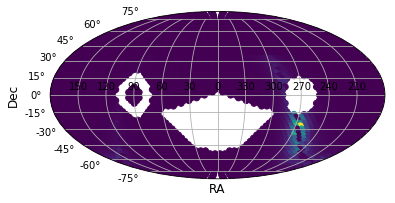

In [349]:
# create a mask column 
Fields['inring'] = np.isin(Fields['pixId'].values, ipix_ring)

df = Fields
fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['inring'] == False ) & (df['inpoly']==False) & (df['indisc']==False)
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 

#### galactic plane

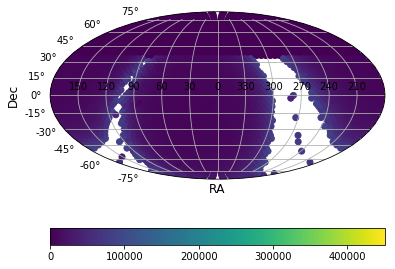

In [30]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
maxStarDens = df['starDensity_r25'].max()
# remove high density galactic plane
slicer = ( df['starDensity_r25'] < 0.01 * maxStarDens ) 
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=True, vmax=0.05*maxStarDens ) 


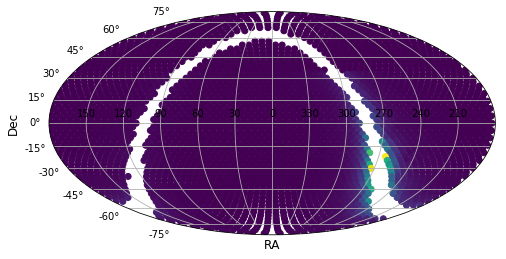

In [31]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

# remove by galactic coordinate
slicer = ( df['fieldGb'] > 5 ) | ( df['fieldGb'] < -5 )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 


#### ecliptic

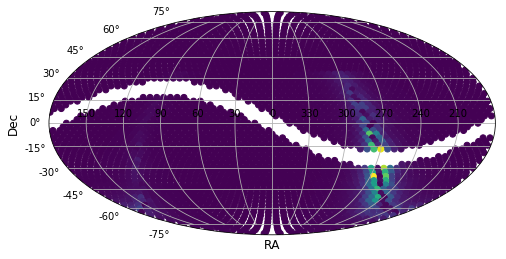

In [32]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['fieldEb'] > 5 ) | ( df['fieldEb'] < -5 )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 


#### select pix use interactive tools

In [293]:
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook

# output to static HTML file
# output_file("line.html")
output_notebook()

Loading BokehJS ...

In [237]:
p = figure(plot_width=800, plot_height=400, )

x = Fields['fieldRa'].values
y = Fields['fieldDec'].values
# add a circle renderer with a size, color, and alpha

# create a colormap
mapper = linear_cmap(field_name='starDensity_r25', palette=Spectral6 ,
                     low=min(Fields['starDensity_r25']) ,high=0.05*max(Fields['starDensity_r25']))


p.circle('fieldRa', 'fieldDec', source=Fields, size=20, alpha=0.5, color=mapper)

p.text(x, y, text=Fields['pixId'].values, text_align='center', text_font_size='3pt')

p.xaxis.axis_label = 'RA'
p.yaxis.axis_label = 'DEC'


In [238]:
# show the results
show(p)


In [177]:
#from IPython.core.display import HTML
#HTML('line.html')

#### others

In [262]:
from ipywidgets import interactive

In [264]:
def f(min, max):
    plt.figure(2)
    hp.mollview(m, fig=2, min=min, max=max)
    hp.graticule()
    plt.show()

# view density interactively
interactive_plot = interactive(f, min=(0, 100000, 1000), max=(10000, 9010980, 1000))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=50000, description='min', max=100000, step=1000), IntSlider(value=451000…

#### utils

In [350]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmin=None, vmax=None, colorbar=True):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    if vmin is None:
        vmin = c.min()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=vmin, vmax=vmax)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

# ------------------------------------------------------------------- #
# builtin star density map
# ------------------------ #
import os
import healpy as hp
from lsst.utils import getPackageDir
from scipy.interpolate import interp1d
from lsst.sims.maf.utils import radec2pix

def load_starmap(flt='r'):
    # get mapdir '/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps'
    mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps') 

    mapfile = 'starDensity_{}_nside_64.npz'.format(flt)

    starMap = np.load( os.path.join(mapDir, mapfile) )
    
    return starMap
      
def get_starDensity(ra=0, dec=0, starMap=None, mag=25):
    '''get star density of a field, from star density map,
    input ra, dec in degree 
    returns stars / (sq degree)
    '''
    ra = ra * np.pi / 180   # convert to radian
    dec = dec * np.pi / 180

    starMapDensity = starMap['starDensity'].copy()
    starMapBins = starMap['bins'].copy()
    starmapNside = hp.npix2nside( np.size(starMapDensity[:,0]) )
    
    ipix = radec2pix(starmapNside, ra, dec) # convert from ra/dec to ipix 
    density = interp1d( starMapBins[1:], starMapDensity[ipix, :] ) (mag)
    return int( density )

#-----------------------------------
# coordinates transform
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec
    

def radec2ecliptic(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import GeocentricTrueEcliptic
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    lon = c.transform_to(GeocentricTrueEcliptic()).lon.degree
    lat = c.transform_to(GeocentricTrueEcliptic()).lat.degree
    
    return lon, lat

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b
